In [1]:
import jax
import pandas as pd

In [2]:
import jax.numpy as jnp
from jax import jit, random, grad

In [3]:
from scipy.stats import genpareto,genexpon
import numpy as np
import matplotlib.pyplot as plt
from graph_tool.generation import random_graph
from graph_tool.spectral import adjacency
import itertools

## Random number generators:
<ol>
    <li> <strong>SF distribution</strong>: obtained by discretization to the nearest integer of the continuous Pareto distribution
$P(K) = \frac{(\gamma - 1)a^{\gamma -1}}{K^\gamma}$ 
which we get using the Generalized pareto distribution $$P(K) = \frac{1}{\sigma}\left(1 + \frac{\xi(K - \mu)}{\sigma}\right)^{\left(-\frac{1}{\xi} - 1\right)} \stackrel{*}{=}  \frac{(\gamma - 1)a^{\gamma -1}}{K^\gamma}$$
$*\text{ by setting } \xi = \frac{1}{\gamma -1},~ \sigma = \frac{a}{\gamma -1}, \mu = a$

    
which can be generated using `scipy.stats.genpareto(c=1/(gamma-1), scale=a/(gamma-1), loc=a)`

the average connectivity $<K>$ can be calculate theoritically $\mathbb{E}\left[K\right] = \mu + \frac{\sigma}{1-\xi} \stackrel{*}{=} \frac{a}{\gamma -2}$</li>
    
  <li><strong>Binomial distribution</strong>: parametrized by the average connectivity $<K>$ we generate from $K \sim B(N, \frac{<k>}{N})$ 
      
which can be generated using `numpy.random.binomial(n=N, p=mean_k/N)`
      
</li>
  <li><strong>Exponential distribution</strong>: obtained by discretization to the nearest integer of the continuous Exponential distribution $P(k) = \frac{1}{\beta} \exp(-\frac{k}{\beta})$</li>
    
which can be generated using `numpy.random.exponential(scale=beta)`

</ol>   

In [4]:
def degree_rv(dist, gamma=None, a=None, beta=None, mean_k=None, N=None):
    if dist == 'sf':
        assert gamma is not None, "gamma must be specified for SF distribution"
        assert a is not None, "mu must be specified for SF distribution"
        return genpareto.rvs(c = 1/(gamma-1), scale=a/(gamma-1), loc=a)
    elif dist == 'binom':
        assert mean_k is not None, "mean_k must be specified for binom distribution"
        assert N is not None, "N must be specified for binom distribution"
        return np.random.binomial(n=N, p=mean_k/N)
    elif dist == 'exp':
        assert beta is not None, "N must be specified for binom distribution"
        return np.random.exponential(scale=beta)

- Stress:   $$s = |y - y^*| = |b^Tx - y^*|$$
- Mismatch:
$$\mathcal{M}(s) = \frac{\mathcal{M}_0}{2}\left[1 + \tanh\left(\frac{s - \epsilon}{\mu}\right)\right]$$

In [59]:
def stress(b, x,target = 0):
    return np.abs(np.dot(b,x) - target)
                  
def M(s, M_0, mu, eps):
    return (M_0/2) * (1 + np.tanh((s - eps)/mu))

# Calcuate CF for different ensembles (T fixed):
- Mismatch function parameters: $\mathcal{M}_0 =4,~ \epsilon=3,~ \mu = 0.01$
- dynamics parameters: $D = 10^{-3},~ dt =0.1,~ tol = 10^{-2}$
- target: $y^* = 0$
- Recurrent weights initilzation $J$: $g_w = 10$
- readout weights initialization $b$: $g_0 = 10,~ c=0.2,~ \alpha=100$


In [6]:
#params for first figure
# dist params
gamma, a = 2.4,1
mean_k, beta = 3.5, 3.5

# output
target = 0

# connectivity params
N=1500
g_0 = 10
g_w = 10

# optimizer params
D = 1e-3

#Mismatch function parameters:
eps = 3 #epsilon tolerance of stress -  if the stress is below eps_s it is zero or very low
mu = 0.01 #steepness (mu) of f(s) in its sigmoidal form M(s)=2a(1-tanh((s-eps)/mu))
M_0 = 2;  #stauration value (a) of f(s) in its sigmoidal form M(s)=2a(1-tanh((s-eps)/mu))

In [7]:
dists = ['sf','binom','exp']
all_combinations = [each_permutation for each_permutation in itertools.product(dists, dists)]
all_combinations[2:]

[('sf', 'exp'),
 ('binom', 'sf'),
 ('binom', 'binom'),
 ('binom', 'exp'),
 ('exp', 'sf'),
 ('exp', 'binom'),
 ('exp', 'exp')]

In [346]:
n_trials = 50
dists = ['sf','binom','exp']
all_combinations = [each_permutation for each_permutation in itertools.product(dists, dists)]
CF = {}
D = {}
for (out_dist, in_dist) in all_combinations:
    #create ensemble using in/out degree distributions:

    
    ## calculate CF over n_trials per ensemble
    
    tot_s = 0
    d = np.zeros((n_trials,))
    for i in range(n_trials):
        g = random_graph(N, deg_sampler=lambda:(degree_rv(dist=in_dist,gamma=gamma,beta=beta, a=a,mean_k=mean_k,N=N)
                                            ,degree_rv(dist=out_dist,gamma=gamma,beta=beta, a=a,mean_k=mean_k,N=N)))
    #topology matrix
        T = np.array(adjacency(g).todense()).astype(np.uint)
        is_s,X,sim_idx = run_trial(T)
        tot_s += is_s
        d[i] = comp_d(X,sim_idx)
    CF[(out_dist, in_dist)] = tot_s/n_trials
    D[(out_dist, in_dist)] = d
    print(out_dist, in_dist, tot_s/n_trials, np.mean(d))

sf sf 0.88 4.931677940818095
sf binom 0.68 4.9329980381378
sf exp 0.64 5.281372418691434
binom sf 0.1 18.835187839340932
binom binom 0.0 45.3497998486994


KeyboardInterrupt: 

In [389]:
def run_dynamics(T, N=1500, g_0=10, b_alpha=100, m_b =0, sparsity=0.2, g_w=10, target=0, D=1e-3, eps=3, mu=0.01, M_0=2, t_int=0, t_max=2000, dt=0.1, T_stop=100, tol=1e-2):
    """
    run dynamics for a given ensemble 
  
    Parameters:
    T: NXN adjacency matrix for a predefined ensemble
    N: network size
    g_0: matrix gain for the vector b initialization
    b_alpha: parameter determining the scale of phenotype fluctuations
    m_b: mean of b[i]
    sparsity (c): fraction of non-zero elements in b
    g_w:matrix gain for J initilization
    target: y*
    D: The amplitude of the random walk
    eps,mu,M_0: parameters for the Mismatch function
    t_int: initial time for the simluation
    dt: the step-size for the dynamics
    t_max: if network does not converge end simulation at t=t_max
    T_stop: if network output y~y* for T_stop time units, then network converged.
    tol: Ms(|y-y*|)< tol is regarded as success to converge

    Returns:
    is_success: 1 if converged, 0 otherwise.
  
    """
    
    
    # initialize b
    b = np.zeros(N,)
    n=int(np.round(N*sparsity))
    idxs = np.random.permutation(range(N))[:n]
    g_b = (1/g_0)*np.sqrt(b_alpha/n);
    b[idxs] = m_b + g_b*np.random.randn(n)
    
    # initialize J
    active_idxs = np.where(T!=0) #the only connections to update
    N_W_n_z = np.sum(T) # number of active connections
    avg_k = np.sum(T,1).mean() # average connectivity
    W_int = np.zeros((N,N))
    W_int[active_idxs] = (g_w/np.sqrt(avg_k))*np.random.randn(N_W_n_z,)
    W_rec = W_int.copy()
    

    
    # trial params
    T_sim = round(t_max/dt)+1;
    is_sucess = 0 #will be set to 1 in case the network converges
    s = np.zeros((T_sim,)) #Will hold stress at all timesteps (not essensial)
    M_s = np.zeros((T_sim,)) #Will hold mismatch function at all timesteps - useful for stopping creterion
    #X_z = X - X.mean()
    #C = X_z.dot(X_z.T)
    
        # initialize x
    X = np.zeros((T_sim,N))
    X[0] = 10 *np.random.randn(N)
    #run trial
    for i in range(T_sim-1):
        s[i] = stress(b, X[i], target=0)
        M_s[i] = 2*(1 + np.tanh((s[i] - eps)/mu))
        
        X[i+1] = X[i] + dt*(np.dot(W_rec,np.tanh(X[i])) - X[i])
        #X_z = X - X.mean()
        #C += X_z.dot(X_z.T)
        #delta = np.sqrt(M_s[i]*dt*D)*np.random.randn(N_W_n_z,)
        #W_rec[active_idxs] = W_rec[active_idxs] + delta
        
        #if i*dt> T_stop:
         #   if ~np.any(M_s[i-int((T_stop/dt)):i] > tol):
          #      is_sucess = 1
           #     break
    
    #d = np.trace(C)**2/np.trace(C.dot(C))
    return X,W_int

In [364]:
comp_d(np.random.randn(1500,100),50)

32.427188076484086

Text(0, 0.5, 'Particioation Ratio d')

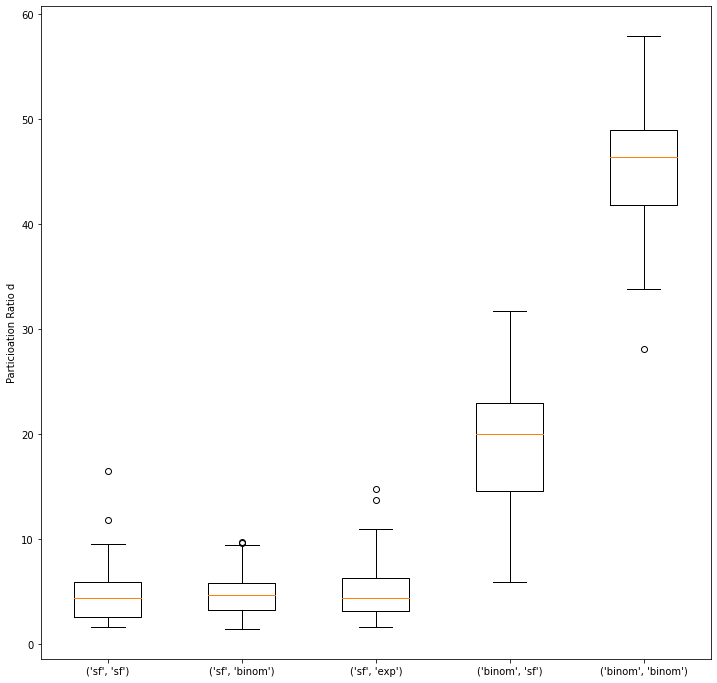

In [350]:
fig, ax = plt.subplots(figsize = (12,12))
df = pd.DataFrame(D)
ax.boxplot(df,labels=df.columns);
ax.set_ylabel('Particioation Ratio d')
#ax = pd.DataFrame(D).boxplot()

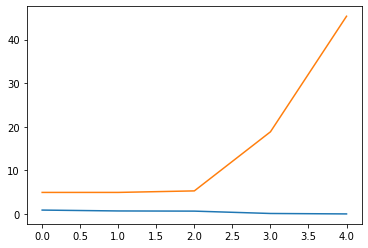

In [352]:
plt.plot([(CF[k],D[k].mean()) for k in CF.keys()])

Text(0, 0.5, 'Particioation Ratio d')

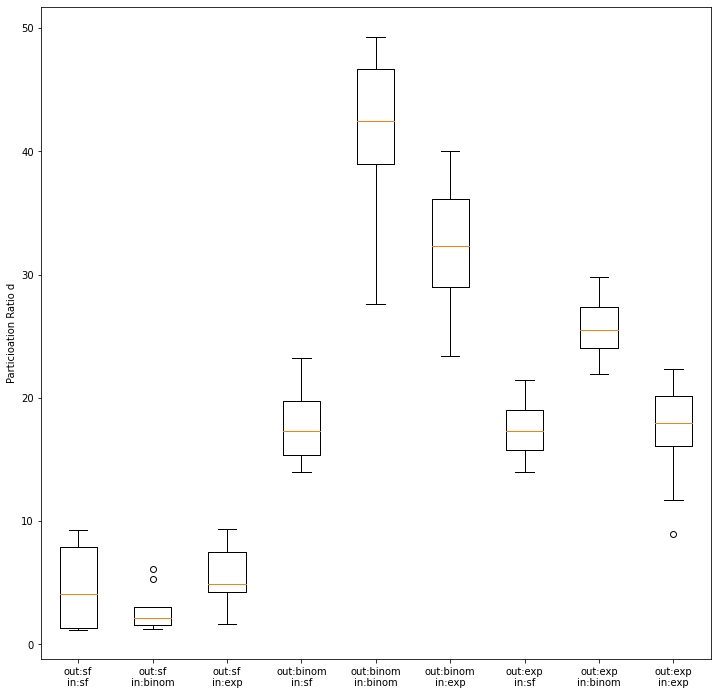

In [175]:
fig, ax = plt.subplots(figsize = (12,12))
df = pd.DataFrame(D)
ax.boxplot(df,labels=v);
ax.set_ylabel('Particioation Ratio d')
#ax = pd.DataFrame(D).boxplot()

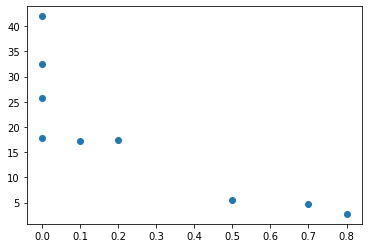

In [181]:
plt.scatter(cfs,ds)

In [432]:
x0 = np.ones((1500,1))
x0[0] = 1

In [429]:
T.dot(x0)[688]

array([1.])

(array([215., 314., 274., 290., 206., 109.,  53.,  20.,  12.,   7.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

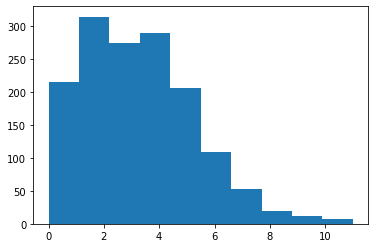

In [434]:
plt.hist(T.dot(x0))

(array([1.482e+03, 1.000e+01, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  1. ,  33.3,  65.6,  97.9, 130.2, 162.5, 194.8, 227.1, 259.4,
        291.7, 324. ]),
 <BarContainer object of 10 artists>)

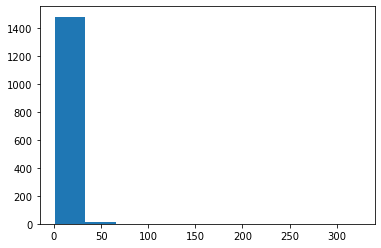

In [435]:
plt.hist(T.T.dot(x0))

In [416]:
in_dist, out_dist = 'binom', 'sf'
g = random_graph(N, deg_sampler=lambda:(degree_rv(dist=in_dist,gamma=gamma,beta=beta, a=a,mean_k=mean_k,N=N)
                                            ,degree_rv(dist=out_dist,gamma=gamma,beta=beta, a=a,mean_k=mean_k,N=N)))
    #topology matrix
T = np.array(adjacency(g).todense()).astype(np.uint)
res_cf,res_d = {},{}
for i in range(20):
    X,W_0 = run_dynamics(T)
    d = comp_d(X,idx)
    is_s_l = []
    ds = []
    for i in range(20):
        is_, Y,sim_idx = run_trial(T,x_0=X[0],W_0=W_0)
        d2 = comp_d(Y,sim_idx)
        ds.append(d2)
        is_s_l.append(is_)
    res_cf[d] = is_s_l
    res_d[d] = ds
# tot_s = 0
# for i in range(10):
#     is_, X,sim_idx = run_trial(T)
#     print(is_,comp_d(X,sim_idx))

In [419]:
res_d

{5.037033873685642: [11.002534561000418,
  7.94948977102333,
  6.201790841656616,
  7.48560657597205,
  3.744098062932751,
  4.425053654495461,
  5.787449912459824,
  3.7957978066860516,
  8.406564513090167,
  8.27695264511078,
  7.999121630873088,
  8.803103326747763,
  4.154529693477914,
  2.4804742113158937,
  2.8749261483722086,
  1.5595037097856845,
  3.0370151631597126,
  5.781360276067527,
  5.787353872659378,
  4.122914457477062],
 5.478559647726411: [11.637698679940968,
  10.212238548837751,
  10.740095572391466,
  6.473502587866671,
  6.042052010843326,
  5.6938271508395975,
  4.477269887573203,
  5.038282860630083,
  9.601211092124972,
  5.529198097463706,
  8.396262472022505,
  7.384904813960935,
  3.6246031244572507,
  5.926230025501106,
  3.4592237214029264,
  4.049049103583348,
  5.9484715953722,
  5.794173659089819,
  4.237902528306891,
  5.151331663169983],
 4.6858061954658154: [8.030449440764635,
  5.339829083095894,
  5.328810118648098,
  4.541800981678411,
  2.24179

In [420]:
{k:np.mean(v) for k,v in res_d.items()}

{5.037033873685642: 5.6837820417181835,
 5.478559647726411: 6.470876459768935,
 4.6858061954658154: 5.204752149269922,
 4.1387115258788265: 5.181752490775194,
 2.415684200339416: 4.2241978217493195,
 5.361755984982819: 7.172102913179081,
 5.651684903934063: 4.596813383992307,
 1.9334745520064678: 3.799779302189566,
 5.341767723170125: 5.888069349189895,
 4.55021747602068: 5.754790368558867,
 2.578127872643904: 5.676156720250921,
 3.8112670254242884: 5.790204173747105,
 2.4012262221244653: 7.747445834769373,
 3.417841994243714: 6.423837508788298,
 2.736084794132313: 6.595700695900204,
 7.251013233910765: 5.106564859092099,
 6.75113553820146: 7.344490855064824,
 3.0883521849483975: 7.003722908037801,
 4.000606925800481: 6.122705430406775,
 3.582765665482274: 5.356228301651532}

In [411]:
cf = 0
for i in range(10):
    is_, Y1, idx_f = run_trial(T,x_0=X[0],W_0=W_0)
    cf+= is_
cf/10

0.3

In [407]:
is_

1

In [232]:
tot_s = 0
for i in range(100):
    is_, X,sim_idx = run_trial_hub(T)
    tot_s += is_
print(tot_s/100)

0.41


In [317]:
is_, X,sim_idx,W_0,W_T = run_trial(T)

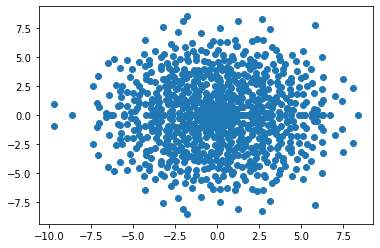

In [319]:
lambda_0 = np.linalg.eigvals(W_0)
plt.scatter(np.real(lambda_0),np.imag(lambda_0))

In [323]:
np.mean(lambda_T > 0)

0.484

In [324]:
dW = W_T-W_0

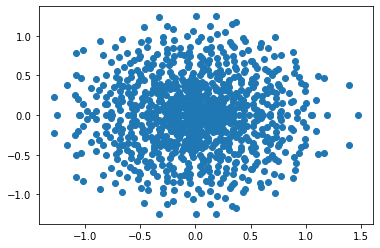

In [325]:
lambda_T = np.linalg.eigvals(dW)
plt.scatter(np.real(lambda_T),np.imag(lambda_T))

In [331]:
np.linalg.matrix_rank(dW)

1177

In [330]:
np.mean(lambda_T > 0.5)

0.09

In [219]:
idx_hub = np.argmax(T.sum(0))
idxs_from_hub = np.where(T[:,idx_hub]!=0)[0]

In [218]:
T.sum()

5214

In [217]:
T[idxs,1478].sum()

721

In [307]:
is_, X, sims = run_trial(T)

In [308]:
is_, sims

(0, 20000)

In [380]:
comp_d(X,10),comp_d2(X,10)

(1.0674599226239294, 1.0674599226239294)

In [370]:
X.shape

(20001, 1500)

In [309]:
def comp_d(X, d_sim):
    X = X[:d_sim]
    X_bar = X.mean(0)
    X_ = X - X_bar
    C = X_.T.dot(X_)/(d_sim)
    return np.trace(C)**2/np.trace(C.dot(C))

In [374]:
X[0][:,None].dot(X[0][None,:]).shape

(1500, 1500)

In [375]:
def comp_d2(X, d_sim):
    X = X[:d_sim]
    X_bar = X.mean(0)
    X_ = X - X_bar
    C = np.zeros((X.shape[1],X.shape[1]))
    for i in range(X.shape[0]):
        C += X_[i][:,None].dot(X_[i][None,:])/d_sim 

    return np.trace(C)**2/np.trace(C.dot(C))

In [353]:
X

array([[-1.86511106e+001,  2.80424472e+000, -8.40201237e+000, ...,
        -7.83639264e+000,  4.54921164e+000, -3.51197155e+000],
       [-1.67859996e+001,  3.32790947e+000, -7.61658710e+000, ...,
        -7.73448376e+000,  4.09429047e+000, -2.08465733e+000],
       [-1.51073996e+001,  3.50207066e+000, -6.90943623e+000, ...,
        -7.82944656e+000,  3.68486143e+000, -4.76545401e-001],
       ...,
       [-1.97626258e-323,  5.71907460e+000,  1.33933048e+000, ...,
         1.35859624e+001,  1.97626258e-323,  5.69914178e+000],
       [-1.97626258e-323,  5.78858784e+000,  1.33672026e+000, ...,
         1.35942385e+001,  1.97626258e-323,  6.23776706e+000],
       [-1.97626258e-323,  5.85104996e+000,  1.33245741e+000, ...,
         1.36004283e+001,  1.97626258e-323,  6.72432720e+000]])

In [59]:
idxs=jnp.mask_indices(N, mask_func=lambda x,k: I!=0)

In [60]:
%%timeit
J*I

1.15 ms ± 3.19 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [84]:
%%timeit
idxs=jnp.mask_indices(N, mask_func=lambda x,k: I!=0)
J[idxs]

13.8 ms ± 75.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
jnp.sum((I>0))

DeviceArray(5136, dtype=int32)

In [30]:
jax.ops.index??

In [62]:
jnp.zeros(N,)

DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [64]:
int(jnp.round(normal(key=key)+1))

0

In [72]:
jax.random.randint(key=key, shape=(10,),minval=0,maxval=10)

Buffer([0, 3, 9, 7, 7, 3, 8, 5, 9, 5], dtype=int32)

In [78]:
%%timeit
jax.random.choice(key, jnp.arange(N), shape=(100,))

756 µs ± 3.58 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [83]:
jax.random.permutation(key, jnp.arange(N))[:100]

DeviceArray([ 590, 1069,  834, 1254, 1316, 1483,  303,  396,  935,  837,
             1206, 1279,  502, 1065,  971,  743, 1312,  874,  139, 1464,
              792, 1015,  732,  970,  581, 1121,   74,  374,  195, 1361,
              959, 1491, 1171, 1150,  756, 1430,  647, 1231,  500,  538,
             1435, 1439,  568,  283, 1246,  214, 1286, 1310,  995,   28,
              313, 1106,  739,  996, 1127, 1112,  108, 1315,  551,  981,
             1428,  471,  710,   44, 1354,   76,    7,  726, 1172, 1273,
               51, 1235, 1223,  600, 1118,  332,  827,  774,  512, 1394,
             1400, 1081,  779,  234,  171, 1393, 1040,  311, 1426, 1117,
              312,  846,  823, 1031, 1079,  344,  470,  295,    3,  877],            dtype=int32)

In [106]:
type(I)

jax.interpreters.xla._DeviceArray

In [108]:
jax.random.normal(key, shape = I.shape)

Buffer([[ 1.2800897 ,  0.34339726, -0.9252373 , ..., -0.63631344,
         -0.7198169 ,  1.0037259 ],
        [ 0.55175924, -0.4854103 , -0.81493306, ..., -0.7870839 ,
          0.9628519 ,  0.90983945],
        [ 0.00231879,  0.23982914,  1.9899902 , ..., -0.02910883,
          0.0237561 ,  1.1612936 ],
        ...,
        [ 1.8353235 ,  0.01348705,  0.3812247 , ..., -0.4578199 ,
          1.1064543 , -0.5750031 ],
        [ 0.3112348 ,  0.5311667 ,  0.5510371 , ..., -0.8669856 ,
          0.59001297,  1.4178063 ],
        [-0.8498853 ,  0.04492616, -0.57068187, ..., -0.32546216,
          1.2898204 , -0.63271385]], dtype=float32)

In [110]:
from jax import jit

In [13]:
@jit
def M(s):
    return 2*(1 + jnp.tanh((s - 3.0)/0.01))

In [14]:
@jit
def F(J,X):
    return jnp.dot(J,jnp.tanh(X)) - X

In [118]:
if jnp.any(b[1:4] > 0):
    print('a')

a


In [120]:
key = random.PRNGKey(0)

In [124]:
random.split(key)

Buffer([[4146024105,  967050713],
        [2718843009, 1272950319]], dtype=uint32)

In [362]:
%%time
run_trial2(I, key)

TypeError: stress() got an unexpected keyword argument 'target'

In [9]:
def run_trial(T, N=1500, g_0=10, b_alpha=100, m_b =0, sparsity=0.2, g_w=10, target=0, D=1e-3, eps=3, mu=0.01, M_0=2, t_int=0, t_max=2000, dt=0.1, T_stop=100, tol=1e-2):
    """
    run dynamics for a given ensemble 
  
    Parameters:
    T: NXN adjacency matrix for a predefined ensemble
    N: network size
    g_0: matrix gain for the vector b initialization
    b_alpha: parameter determining the scale of phenotype fluctuations
    m_b: mean of b[i]
    sparsity (c): fraction of non-zero elements in b
    g_w:matrix gain for J initilization
    target: y*
    D: The amplitude of the random walk
    eps,mu,M_0: parameters for the Mismatch function
    t_int: initial time for the simluation
    dt: the step-size for the dynamics
    t_max: if network does not converge end simulation at t=t_max
    T_stop: if network output y~y* for T_stop time units, then network converged.
    tol: Ms(|y-y*|)< tol is regarded as success to converge

    Returns:
    is_success: 1 if converged, 0 otherwise.
  
    """
    
    
    # initialize b
    b = jnp.zeros(N,)
    n=int(jnp.round(N*sparsity))
    idxs = random.permutation(key,jnp.arange(N))[:n]
    g_b = (1/g_0)*jnp.sqrt(b_alpha/n);
    b = jax.ops.index_update(b,idxs,m_b g_b*jax.random.normal(key, shape=(n,)))

    
    # initialize J
    #active_idxs = np.where(T!=0) #the only connections to update
    N_W_n_z = jnp.sum(T) # number of active connections
    avg_k = np.sum(T,1).mean() # average connectivity
    J = (g_w/np.sqrt(avg_k))* jax.random.normal(key, shape = T.shape)
    J = J*T
    
    # initialize x
    X = 10*jax.random.normal(key, shape=(N,))
    
    # trial params
    T_sim = round(t_max/dt)+1;
    is_sucess = 0 #will be set to 1 in case the network converges
    s = jnp.zeros((T_sim,)) #Will hold stress at all timesteps (not essensial)
    M_s = jnp.zeros((T_sim,)) #Will hold mismatch function at all timesteps - useful for stopping creterion
    C = 
    #run trial
    for i in range(T_sim-1):
        s = jax.ops.index_update(s, i, stress(b, X, target=0))
        M_s = jax.ops.index_update(M_s,i, M(s[i]))
        
        X = X + dt*F(J,X)
        delta = np.sqrt(M_s[i]*dt*D)*jax.random.normal(key=key, shape=(T.shape)) * I
        J += delta
        
        if i*dt> T_stop:
            if ~jnp.any(M_s[i-int((T_stop/dt)):i] > tol):
                is_sucess = 1
                break
    return is_sucess

In [66]:
np.zeros((2,3))[0]

array([0., 0., 0.])

In [394]:
def run_trial(T, x_0 = None, W_0=None,  N=1500, g_0=10, b_alpha=100, m_b =0, sparsity=0.2, g_w=10, target=0, D=1e-3, eps=3, mu=0.01, M_0=2, t_int=0, t_max=2000, dt=0.1, T_stop=100, tol=1e-2):
    """
    run dynamics for a given ensemble 
  
    Parameters:
    T: NXN adjacency matrix for a predefined ensemble
    N: network size
    g_0: matrix gain for the vector b initialization
    b_alpha: parameter determining the scale of phenotype fluctuations
    m_b: mean of b[i]
    sparsity (c): fraction of non-zero elements in b
    g_w:matrix gain for J initilization
    target: y*
    D: The amplitude of the random walk
    eps,mu,M_0: parameters for the Mismatch function
    t_int: initial time for the simluation
    dt: the step-size for the dynamics
    t_max: if network does not converge end simulation at t=t_max
    T_stop: if network output y~y* for T_stop time units, then network converged.
    tol: Ms(|y-y*|)< tol is regarded as success to converge

    Returns:
    is_success: 1 if converged, 0 otherwise.
  
    """
    
    
    # initialize b
    b = np.zeros(N,)
    n=int(np.round(N*sparsity))
    idxs = np.random.permutation(range(N))[:n]
    g_b = (1/g_0)*np.sqrt(b_alpha/n);
    b[idxs] = m_b + g_b*np.random.randn(n)
    
    active_idxs = np.where(T!=0) #the only connections to update
    N_W_n_z = np.sum(T) # number of active connections
    avg_k = np.sum(T,1).mean() # average connectivity
    
    # initialize J
    if W_0 is not None:
        W_rec = W_0
    else:

        W_int = np.zeros((N,N))
        W_int[active_idxs] = (g_w/np.sqrt(avg_k))*np.random.randn(N_W_n_z,)
        W_rec = W_int.copy()
    

    
    # trial params
    T_sim = round(t_max/dt)+1;
    is_sucess = 0 #will be set to 1 in case the network converges
    s = np.zeros((T_sim,)) #Will hold stress at all timesteps (not essensial)
    M_s = np.zeros((T_sim,)) #Will hold mismatch function at all timesteps - useful for stopping creterion
    #X_z = X - X.mean()
    #C = X_z.dot(X_z.T)
    
        # initialize x
    X = np.zeros((T_sim,N))
    if x_0 is not None:
        X[0] = x_0
    else:
        X[0] = 10 *np.random.randn(N)
    #run trial
    for i in range(T_sim-1):
        s[i] = stress(b, X[i], target=0)
        M_s[i] = 2*(1 + np.tanh((s[i] - eps)/mu))
        
        X[i+1] = X[i] + dt*(np.dot(W_rec,np.tanh(X[i])) - X[i])
        #X_z = X - X.mean()
        #C += X_z.dot(X_z.T)
        delta = np.sqrt(M_s[i]*dt*D)*np.random.randn(N_W_n_z,)
        W_rec[active_idxs] = W_rec[active_idxs] + delta
        
        if i*dt> T_stop:
            if ~np.any(M_s[i-int((T_stop/dt)):i] > tol):
                is_sucess = 1
                break
    
    #d = np.trace(C)**2/np.trace(C.dot(C))
    return is_sucess, X, i+1

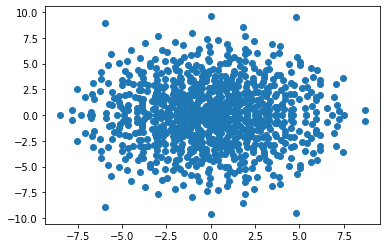

In [315]:
x = np.linalg.eigvals(W_rec)
plt.scatter(np.real(x),np.imag(x))

In [334]:
np.argmax(T.sum(0))

1402

In [339]:
T[1402,1402] = 1

In [340]:
def run_trial_hub(T,top_k=1, N=1500, g_0=10, b_alpha=100, m_b =0, sparsity=0.2, g_w=10, target=0, D=1e-3, eps=3, mu=0.01, M_0=2, t_int=0, t_max=2000, dt=0.1, T_stop=100, tol=1e-2):
    """
    run dynamics for a given ensemble 
  
    Parameters:
    T: NXN adjacency matrix for a predefined ensemble
    N: network size
    g_0: matrix gain for the vector b initialization
    b_alpha: parameter determining the scale of phenotype fluctuations
    m_b: mean of b[i]
    sparsity (c): fraction of non-zero elements in b
    g_w:matrix gain for J initilization
    target: y*
    D: The amplitude of the random walk
    eps,mu,M_0: parameters for the Mismatch function
    t_int: initial time for the simluation
    dt: the step-size for the dynamics
    t_max: if network does not converge end simulation at t=t_max
    T_stop: if network output y~y* for T_stop time units, then network converged.
    tol: Ms(|y-y*|)< tol is regarded as success to converge

    Returns:
    is_success: 1 if converged, 0 otherwise.
  
    """
    
    
    # initialize b
    b = np.zeros(N,)
    n=int(np.round(N*sparsity))
    idxs = np.random.permutation(range(N))[:n]
    g_b = (1/g_0)*np.sqrt(b_alpha/n);
    b[idxs] = m_b + g_b*np.random.randn(n)
    
    # initialize J
    active_idxs = np.where(T!=0) #the only connections to update
    N_W_n_z = np.sum(T) # number of active connections
    avg_k = np.sum(T,1).mean() # average connectivity
    W_int = np.zeros((N,N))
    W_int[active_idxs] = (g_w/np.sqrt(avg_k))*np.random.randn(N_W_n_z,)
    W_rec = W_int.copy()
    
    
    
    idxs_from_hub = np.where(T[:,idx_hub]!=0)[0]
    tot_N_z = len(idxs_from_hub)
    # trial params
    T_sim = round(t_max/dt)+1;
    is_sucess = 0 #will be set to 1 in case the network converges
    s = np.zeros((T_sim,)) #Will hold stress at all timesteps (not essensial)
    M_s = np.zeros((T_sim,)) #Will hold mismatch function at all timesteps - useful for stopping creterion
    #X_z = X - X.mean()
    #C = X_z.dot(X_z.T)
    
        # initialize x
    X = np.zeros((T_sim,N))
    X[0] = 10 *np.random.randn(N)
    #run trial
    for i in range(T_sim-1):
        s[i] = stress(b, X[i], target=0)
        M_s[i] = 2*(1 + np.tanh((s[i] - eps)/mu))
        
        X[i+1] = X[i] + dt*(np.dot(W_rec,np.tanh(X[i])) - X[i])
        #X_z = X - X.mean()
        #C += X_z.dot(X_z.T)
        delta = np.sqrt(M_s[i]*dt*D)*np.random.randn(tot_N_z,)
        W_rec[idxs_from_hub,idx_hub] = W_rec[idxs_from_hub,idx_hub] + delta
        
        if i*dt> T_stop:
            if ~np.any(M_s[i-int((T_stop/dt)):i] > tol):
                is_sucess = 1
                break
    
    #d = np.trace(C)**2/np.trace(C.dot(C))
    return is_sucess, X, i+1 

In [355]:
import jax

In [361]:
X = np.random.randn(100,1)
np.dot(X,X.T)

array([[ 1.10915221,  1.69437341,  0.94914989, ...,  0.10496568,
         1.18132917, -0.20823615],
       [ 1.69437341,  2.58837446,  1.44994918, ...,  0.16034865,
         1.80463304, -0.31810764],
       [ 0.94914989,  1.44994918,  0.81222893, ...,  0.08982371,
         1.01091486, -0.17819675],
       ...,
       [ 0.10496568,  0.16034865,  0.08982371, ...,  0.00993353,
         0.11179622, -0.01970663],
       [ 1.18132917,  1.80463304,  1.01091486, ...,  0.11179622,
         1.25820296, -0.2217869 ],
       [-0.20823615, -0.31810764, -0.17819675, ..., -0.01970663,
        -0.2217869 ,  0.03909499]])

In [352]:
# sin() - not easy
# 2 fixed point (input dependent)

In [353]:
is_success, y,s = run_trial2(T,t_max=2000)

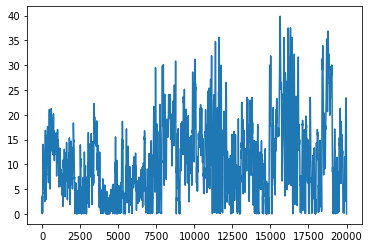

In [354]:
plt.plot(s)

In [350]:
s[-10:]

array([4.89120476, 5.03552373, 5.14841474, 5.13927334, 5.02651574,
       4.89355793, 4.89165453, 4.88843444, 4.7572052 , 0.        ])

In [336]:
is_success

0

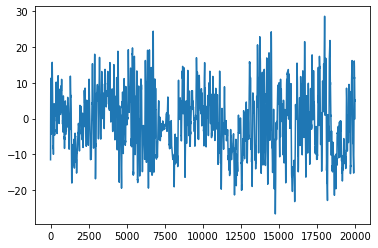

In [349]:
plt.plot(y)

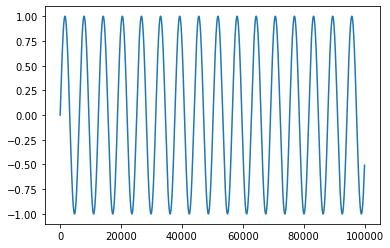

In [280]:
plt.plot(np.sin(np.arange(100000)/1000))

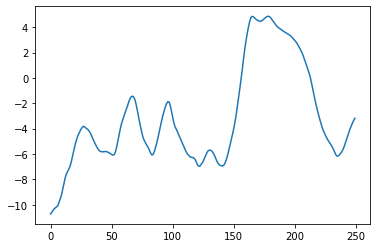

In [249]:
plt.plot(y[13750:14000])

In [240]:
np.arange(13750,14000)

array([13750, 13751, 13752, 13753, 13754, 13755, 13756, 13757, 13758,
       13759, 13760, 13761, 13762, 13763, 13764, 13765, 13766, 13767,
       13768, 13769, 13770, 13771, 13772, 13773, 13774, 13775, 13776,
       13777, 13778, 13779, 13780, 13781, 13782, 13783, 13784, 13785,
       13786, 13787, 13788, 13789, 13790, 13791, 13792, 13793, 13794,
       13795, 13796, 13797, 13798, 13799, 13800, 13801, 13802, 13803,
       13804, 13805, 13806, 13807, 13808, 13809, 13810, 13811, 13812,
       13813, 13814, 13815, 13816, 13817, 13818, 13819, 13820, 13821,
       13822, 13823, 13824, 13825, 13826, 13827, 13828, 13829, 13830,
       13831, 13832, 13833, 13834, 13835, 13836, 13837, 13838, 13839,
       13840, 13841, 13842, 13843, 13844, 13845, 13846, 13847, 13848,
       13849, 13850, 13851, 13852, 13853, 13854, 13855, 13856, 13857,
       13858, 13859, 13860, 13861, 13862, 13863, 13864, 13865, 13866,
       13867, 13868, 13869, 13870, 13871, 13872, 13873, 13874, 13875,
       13876, 13877,

In [236]:
np.arange(0,250,0.1)

array([0.000e+00, 1.000e-01, 2.000e-01, ..., 2.497e+02, 2.498e+02,
       2.499e+02])

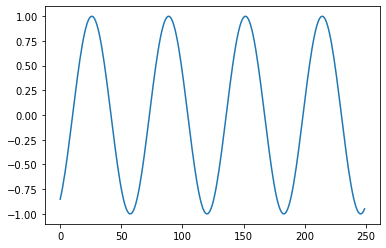

In [254]:
plt.plot(np.sin(np.arange(13750,14000)/10))

In [ ]:
plt.plot(np.linspace())